In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

ModuleNotFoundError: No module named 'tqdm'

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
df = pd.read_csv('../data/desafio_ia_vortex_v1/dataset.csv')
print(f"Classes únicas encontradas no dataset: {df['label'].unique()}")

# Label encoding
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])

# Exibir a correspondência entre labels e números
for i, class_name in enumerate(le.classes_):
    print(f'{class_name} -> {i}')

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label_enc'], random_state=42)


Classes únicas encontradas no dataset: ['cow' 'goat' 'ostrich' 'pigeon' 'iguana' 'possum' 'peacock' 'cat'
 'lizard' 'horse']
cat -> 0
cow -> 1
goat -> 2
horse -> 3
iguana -> 4
lizard -> 5
ostrich -> 6
peacock -> 7
pigeon -> 8
possum -> 9


In [4]:
class AnimalsDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.annotations = dataframe.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        if index >= len(self.annotations):
            raise IndexError("Index out of bounds")

        img_path = os.path.join(self.root_dir, self.annotations.loc[index, 'image_path'])
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            raise FileNotFoundError(f'Arquivo não encontrado: {img_path}.')


        y_label = torch.tensor(self.annotations.loc[index, 'label_enc'])

        if self.transform:
            image = self.transform(image)

        return image, y_label

In [5]:
class AnimalsSubset(Dataset):
      def __init__(self, dataframe, root_dir, base_transform, extra_transform, target_labels):
        self.df = dataframe
        self.root = root_dir
        self.base_transform = base_transform
        self.extra_transform = extra_transform
        self.target_labels = target_labels

      def __len__(self):
        return len(self.df)

      def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.df.loc[idx, 'image_path'])
        img = Image.open(img_path).convert('RGB')
        lbl = self.df.loc[idx, 'label_enc']
        if lbl in self.target_labels:
            img = self.extra_transform(img)
        img = self.base_transform(img)
        return img, torch.tensor(lbl)

In [6]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),   # corta e redimensiona aleatoriamente
    transforms.RandomHorizontalFlip(p=0.5),               # flip horizontal com 50% de chance
    transforms.RandomRotation(degrees=15),                # rotaciona até ±15°
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Para validação/teste, apenas redimensiona e normaliza
val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [7]:
train_dataset = AnimalsDataset(train_df, root_dir='../data', transform=train_transform)
val_dataset   = AnimalsDataset(test_df,   root_dir='../data', transform=val_transform)

# 1) Conta quantos exemplos há de cada classe no train_df
train_class_counts = train_df['label_enc'].value_counts().sort_index().values

# 2) Gera pesos por classe (inversamente proporcionais ao número de exemplos)
total_count = sum(train_class_counts)
train_class_weights = [total_count / c for c in train_class_counts]

# 3) Gera peso para cada amostra (com base no label)
sample_weights = train_df['label_enc'].apply(lambda lbl: train_class_weights[lbl]).values

# 4) Cria o sampler
from torch.utils.data import WeightedRandomSampler
train_sampler = WeightedRandomSampler(
    weights=sample_weights,           # vetor de tamanho N
    num_samples=len(sample_weights),  # quantas amostras por época (geralmente N)
    replacement=True
)

# 5) DataLoader para treino usando sampler em vez de shuffle
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    sampler=train_sampler,
    num_workers=2
)

# 6) DataLoader para validação/teste (normalmente sem sampler, só shuffle=False)
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=2
)


In [8]:
backbone = models.resnet18(pretrained=True)

for name, param in backbone.named_parameters():
    if "layer4" in name or "fc" in name:
      param.requires_grad = True
    else:
      param.requires_grad = False

num_ftrs = backbone.fc.in_features
backbone.fc = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(p=0.5),
    nn.Linear(512, 10)
)

model = backbone.to(device)

/home/mariaclara/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mariaclara/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
def train_epoch(model, dataloader, loss_fn, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader):
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Original:
# def eval_epoch(model, dataloader, loss_fn):
#     model.eval()
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     with torch.no_grad(): # inference_mode
#         for inputs, labels in tqdm(dataloader):
#             outputs = model(inputs)
#             loss = loss_fn(outputs, labels)
#             running_loss += loss.item() * inputs.size(0)
#             _, preds = torch.max(outputs, 1)
#             correct += torch.sum(preds == labels).item()
#             total += labels.size(0)
#     epoch_loss = running_loss / total
#     epoch_acc = correct / total
#     return epoch_loss, epoch_acc

def eval_epoch(model, dataloader, loss_fn, confidence_threshold=0.8):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    total_known = 0

    with torch.inference_mode():
        for inputs, labels in tqdm(dataloader):
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            probs = torch.softmax(outputs, dim=1)
            confidences, preds = torch.max(probs, 1)

            for i in range(len(labels)):
                if confidences[i] > confidence_threshold:
                    total_known += 1
                    if preds[i] == labels[i]:
                        correct += 1
            total += labels.size(0)

    epoch_loss = running_loss / total
    if total_known > 0:
        epoch_acc = correct / total_known  # só considera as predições válidas
    else:
        epoch_acc = 0
    return epoch_loss, epoch_acc


In [10]:
def train_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def eval_epoch(model, dataloader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

model.to(device)

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, backbone.parameters()),
    lr=1e-4
)
weights_tensor = torch.tensor(train_class_weights, dtype=torch.float).to(device)
loss_fn   = nn.CrossEntropyLoss(weight=weights_tensor)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,       # reduz LR pela metade
    patience=3,       # espera 3 épocas sem melhora antes de reduzir
)

max_epochs = 40
n_epochs_stop = 10
best_val_loss = float('inf')
epochs_no_improve = 0

train_loss_list = []
train_acc_list  = []
val_loss_list   = []
val_acc_list    = []


for epoch in range(1, max_epochs + 1):
    # 1) Treinar
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc  = correct / total

    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels).item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_acc  = val_correct / val_total

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_resnet18_finetuned.pth')
        print(f" → Salvo melhor modelo (época {epoch}, Val Loss {val_loss:.4f})")
    else:
        epochs_no_improve += 1


    print(
        f"Época {epoch}/{max_epochs} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
    )

    if epochs_no_improve >= n_epochs_stop:
        print(
            f"\nEarly Stopping na época {epoch} "
            f"(sem melhora de val_loss por {n_epochs_stop} épocas)."
        )
        break

model.load_state_dict(torch.load('best_resnet18_finetuned.pth'))
print("Melhor modelo recarregado de 'best_resnet18_finetuned.pth'.")

 → Salvo melhor modelo (época 1, Val Loss 0.7704)
Época 1/40 | Train Loss: 1.3725, Train Acc: 0.4589 | Val Loss: 0.7704, Val Acc: 0.7907
 → Salvo melhor modelo (época 2, Val Loss 0.4215)
Época 2/40 | Train Loss: 0.5669, Train Acc: 0.7571 | Val Loss: 0.4215, Val Acc: 0.8930
 → Salvo melhor modelo (época 3, Val Loss 0.2977)
Época 3/40 | Train Loss: 0.3410, Train Acc: 0.8538 | Val Loss: 0.2977, Val Acc: 0.9163
 → Salvo melhor modelo (época 4, Val Loss 0.2446)
Época 4/40 | Train Loss: 0.2648, Train Acc: 0.8923 | Val Loss: 0.2446, Val Acc: 0.9349
 → Salvo melhor modelo (época 5, Val Loss 0.2403)
Época 5/40 | Train Loss: 0.2007, Train Acc: 0.9161 | Val Loss: 0.2403, Val Acc: 0.9419
 → Salvo melhor modelo (época 6, Val Loss 0.2014)
Época 6/40 | Train Loss: 0.1647, Train Acc: 0.9388 | Val Loss: 0.2014, Val Acc: 0.9558
 → Salvo melhor modelo (época 7, Val Loss 0.1710)
Época 7/40 | Train Loss: 0.1377, Train Acc: 0.9342 | Val Loss: 0.1710, Val Acc: 0.9628
 → Salvo melhor modelo (época 8, Val Loss

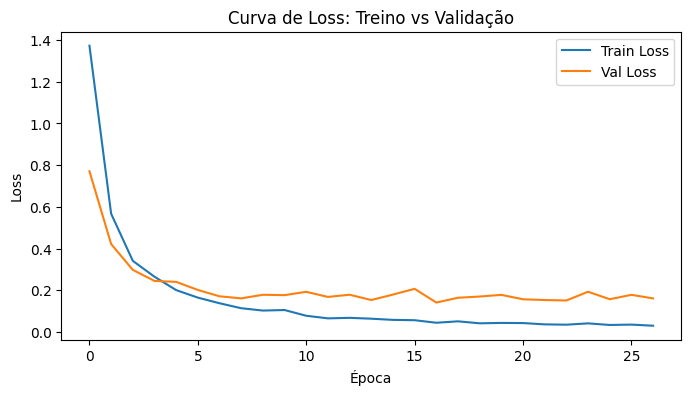

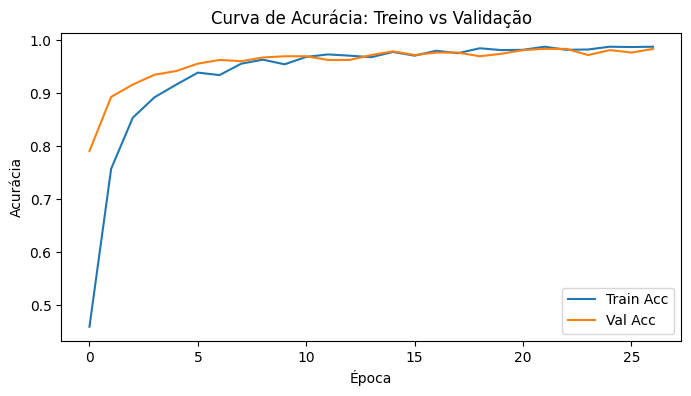

In [15]:

plt.figure(figsize=(8,4))
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list,   label='Val Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curva de Loss: Treino vs Validação')
plt.legend()
plt.show()


plt.figure(figsize=(8,4))
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list,   label='Val Acc')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.title('Curva de Acurácia: Treino vs Validação')
plt.legend()
plt.show()

In [16]:

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Calcula métricas:
acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
rec  = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1   = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print("==== Métricas Pós‐Aprimoramento ====")
print(f"Acurácia (accuracy):             {acc:.4f}")
print(f"Precisão (precision, weighted):  {prec:.4f}")
print(f"Recall (recall, weighted):       {rec:.4f}")
print(f"F1‐score (f1, weighted):         {f1:.4f}\n")

# Relatório completo por classe:
class_names = le.classes_.tolist()  # ex: ['cat','cow','goat',...]
print("==== Relatório por classe ====")
print(classification_report(all_labels, all_preds,
                            target_names=class_names,
                            zero_division=0))



==== Métricas Pós‐Aprimoramento ====
Acurácia (accuracy):             0.9767
Precisão (precision, weighted):  0.9787
Recall (recall, weighted):       0.9767
F1‐score (f1, weighted):         0.9771

==== Relatório por classe ====
              precision    recall  f1-score   support

         cat       1.00      0.99      0.99        99
         cow       0.98      0.98      0.98        55
        goat       0.98      0.95      0.96        55
       horse       0.77      0.83      0.80        12
      iguana       1.00      0.98      0.99        43
      lizard       0.97      1.00      0.98        56
     ostrich       1.00      1.00      1.00        43
     peacock       1.00      1.00      1.00        43
      pigeon       0.80      1.00      0.89        12
      possum       1.00      0.83      0.91        12

    accuracy                           0.98       430
   macro avg       0.95      0.96      0.95       430
weighted avg       0.98      0.98      0.98       430



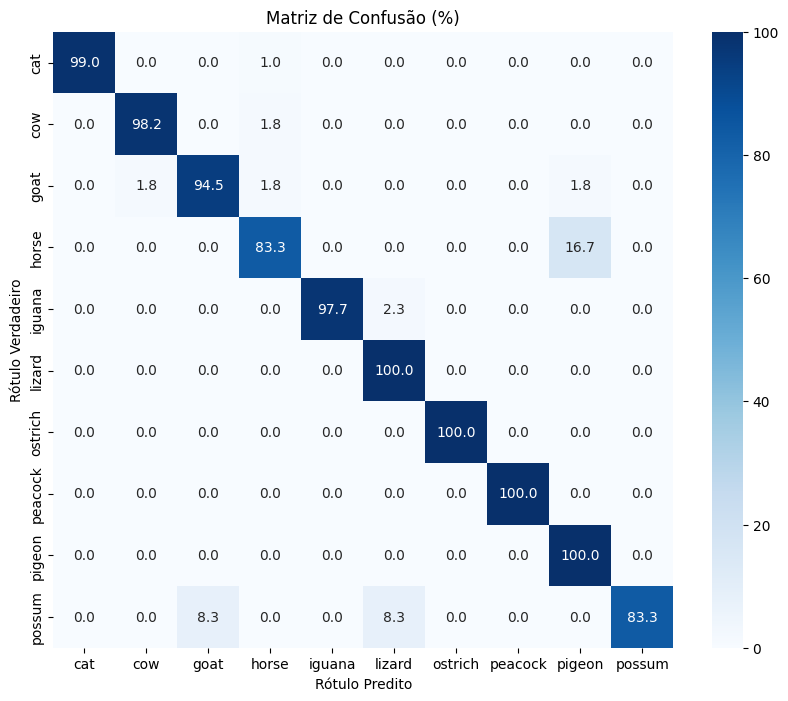

In [17]:

cm = confusion_matrix(all_labels, all_preds)

# Normalizando por linha (cada linha soma 100%)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

plt.title("Matriz de Confusão (%)")
plt.ylabel("Rótulo Verdadeiro")
plt.xlabel("Rótulo Predito")
plt.show()

In [14]:
torch.save(model, 'classification_model_v4')